1.12.0
[[22. 28.]
 [49. 64.]]


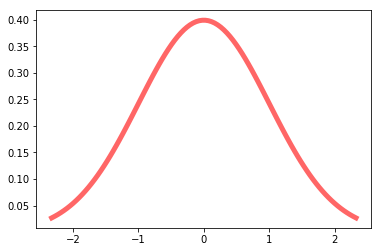

In [1]:
# set up anaconda environment (YMMV)
# conda create -n tensorflow python=3.6 anaconda
# conda activate tensorflow
# conda update --all
# conda install scipy pandas scikit-learn cython matplotlib plotly nose statsmodels ipykernel
# conda install -c  'conda-forge' xgboost catboost lightgbm
# pip install --ignore-installed --upgrade tensorflow_gpu-1.8.0-cp36-cp36m-linux_x86_64.whl
# conda update --all
# sudo /home/ubuntu/anaconda3/envs/tensorflow5/bin/python -m ipykernel install --name tensorflow
# sudo reboot

import time
from itertools import product
import random
random.seed(1744)

import numpy as np
#np.random.seed(1744)
from scipy.stats import norm, truncnorm
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils.testing import all_estimators

import statsmodels.discrete.discrete_model

# popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
# conda install -c conda-forge xgboost
import xgboost 
# Yandex CatBoost https://catboost.yandex/
# conda install -c conda-forge catboost
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
# conda install -c conda-forge lightgbm
import lightgbm as lgb 

import tensorflow as tf
#tf.set_random_seed(1744)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

sess = tf.Session()
print (sess.run(c))

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense, Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
K.set_session(sess)
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

In [2]:
npoints = 2000
distspec0 = [25, 25, 50]
distspec1 = [80,80,20]

def gen_data(distspec0, distspec1, npoints):
    # create 100x100 grid
    # distro centered at 25,25, with normal distribution sd 50, truncate at 0 and 100
    locx, locy, my_std = distspec0
    # define clip a,b in terms of locx, my_std
    clipmin, clipmax=0,100
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var1_x = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    a, b = (clipmin - locy) / my_std, (clipmax - locy) / my_std
    var1_y = truncnorm.rvs(a,b, loc=locy, scale=my_std, size=npoints)
    class1 = np.array([var1_x,var1_y, [0]*npoints]).T
    print(class1.shape)

    # 2nd distro centered at 80, 80, sd 20, to create a nonlinear decision boundary
    locx, locy, my_std = distspec1
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var2_x = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    a, b = (clipmin - locx) / my_std, (clipmax - locx) / my_std
    var2_y = truncnorm.rvs(a,b, loc=locx, scale=my_std, size=npoints)
    class2 = np.array([var2_x,var2_y, [1]*npoints]).T
    print(class2.shape)

    # combine 2 distros for some kurtosis
    #tmp1_x = truncnorm.rvs(-3,1, loc=75, scale=25, size=npoints//2 )
    #tmp1_y = truncnorm.rvs(-3,1, loc=75, scale=25, size=npoints//2)
    #tmp2_x = truncnorm.rvs(-4,1, loc=80, scale=20, size=npoints//2 )
    #tmp2_y = truncnorm.rvs(-4,1, loc=80, scale=20, size=npoints//2)
    #var2_x = np.vstack([tmp1_x, tmp2_x]).T
    #var2_y = np.vstack([tmp1_y, tmp2_y]).T
    #class2 = np.vstack([var2_x,var2_y])
    #print(class2.shape)
    #class2 = np.hstack([class2, np.array([1]*npoints).reshape(npoints,1)])
    #print(class2.shape)
    
    data = np.vstack([class1, class2])
    print(data.shape)
    return data, class1, class2

data, class1, class2 = gen_data(distspec0, distspec1, npoints)
cvdata, class1_cv, class2_cv = gen_data(distspec0, distspec1, npoints)
testdata, class1_test, class2_test = gen_data(distspec0, distspec1, npoints)

pd.DataFrame(data, columns=['x', 'y', 'class'])

(2000, 3)
(2000, 3)
(4000, 3)
(2000, 3)
(2000, 3)
(4000, 3)
(2000, 3)
(2000, 3)
(4000, 3)


x          y  class
0     53.062049  39.100068    0.0
1     25.541630   3.862657    0.0
2     25.674870  38.981438    0.0
3     34.455483  78.701051    0.0
4     31.220290  91.271136    0.0
5     21.386268  67.037492    0.0
6     10.127640  85.491778    0.0
7     58.935245  84.134868    0.0
8     71.411841  61.437064    0.0
9     35.796680  85.243175    0.0
10    46.244208  57.454722    0.0
11    48.000921  65.410940    0.0
12     2.998461  75.461234    0.0
13    33.374563  30.839142    0.0
14     0.506818   5.128628    0.0
15    54.787084  57.506444    0.0
16    19.084574  78.958534    0.0
17    65.272580  79.411526    0.0
18    25.153520   2.333048    0.0
19    23.920908  45.817639    0.0
20    53.720022  97.672061    0.0
21    43.712430   2.204204    0.0
22    10.574721  58.075119    0.0
23    12.156695   8.708408    0.0
24    18.582796  52.674814    0.0
25    66.673920   5.444356    0.0
26    50.600514  34.969243    0.0
27    60.512158  37.240761    0.0
28    33.095059  12.981325    0.0
29    29.648822  98.267379    0.0
...         ...        ...    ...
3970  71.068637  67.462358    1.0
3971  61.043909  58.590059    1.0
3972  70.633984  69.159621    1.0
3973  70.372272  64.717298    1.0
3974  68.998481  93.359453    1.0
3975  69.463187  79.236762    1.0
3976  83.357994  46.074904    1.0
3977  70.278062  81.128230    1.0
3978  80.014116  43.034995    1.0
3979  96.813765  87.886134    1.0
3980  84.434448  94.742669    1.0
3981  78.868200  73.567216    1.0
3982  81.168206  97.935823    1.0
3983  82.929983  81.709692    1.0
3984  70.177460  81.094403    1.0
3985  87.155993  69.543173    1.0
3986  93.220197  86.042006    1.0
3987  78.402673  90.602409    1.0
3988  85.004701  53.090282    1.0
3989  95.486854  37.222307    1.0
3990  89.084269  87.009092    1.0
3991  69.021251  49.720144    1.0
3992  85.966233  86.260607    1.0
3993  81.856833  48.866936    1.0
3994  50.831272  80.165997    1.0
3995  58.078016  69.352240    1.0
3996  37.511548  97.151997    1.0
3997  49.497077  57.908287    1.0
3998  85.078771  93.900391    1.0
3999  91.685184  86.722472    1.0

[4000 rows x 3 columns]

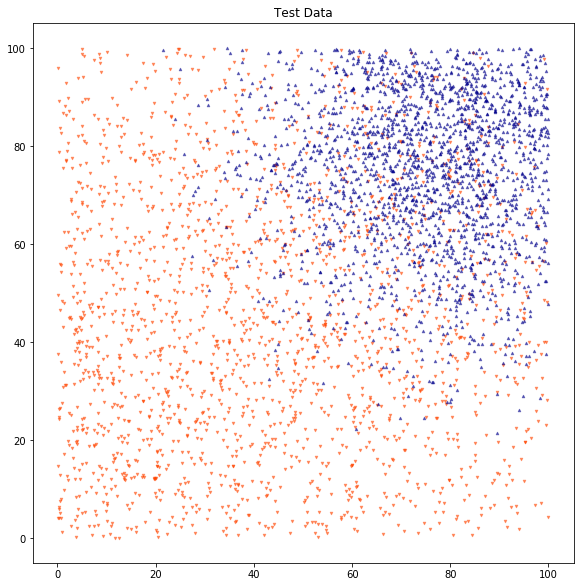

In [3]:
def class_chart(X1, X2, probas, title=""):
    
    trace1 = Scatter(
        x = X1[:,0],
        y = X1[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="orangered"
        )
    )

    trace2 = Scatter(
        x = X2[:,0],
        y = X2[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="darkblue"
        )
    )
    data = [trace1, trace2]

    if probas is not None:
        trace3 = Scatter(
            x = probas[:,0],
            y = probas[:,1],
            mode = 'markers',
            marker = dict(
                size = 4,
                opacity = 0.5*abs(probas[:,2]-0.5),
                color = probas[:,2]-0.5,
                colorscale=[[0.0, 'rgb(165,0,38)'], 
                            [0.1111111111111111, 'rgb(215,48,39)'], 
                            [0.2222222222222222, 'rgb(244,109,67)'], 
                            [0.3333333333333333, 'rgb(253,174,97)'], 
                            [0.4444444444444444, 'rgb(254,224,144)'], 
                            [0.5555555555555556, 'rgb(224,243,248)'], 
                            [0.6666666666666666, 'rgb(171,217,233)'], 
                            [0.7777777777777778, 'rgb(116,173,209)'], 
                            [0.8888888888888888, 'rgb(69,117,180)'], 
                            [1.0, 'rgb(49,54,149)']],                
                symbol = 'square'
            )
        )
        
        data = [trace1, trace2, trace3]
        
    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=640,
        showlegend=False,
        xaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        )
    )

    fig = Figure(data=data, layout=layout)

    return iplot(fig)

# plotly may slow down the browser with this many complex charts
# also doesn't render in github because it's all JS

dpi = 96

def class_chart_matplotlib(X1, X2, probas, title="", widget=None, markersize=6, bgsize=20):
    if widget is None:
        fig, widget = plt.subplots(figsize=(931/dpi,954/dpi))
    #plt.figure(figsize=(12,12))
    widget.scatter(X1[:,0], X1[:,1], s=markersize, c='orangered', marker='v', alpha=0.5)
    widget.scatter(X2[:,0], X2[:,1], s=markersize, c='darkblue', marker='^', alpha=0.5)
    if probas is not None:
        widget.scatter(probas[:,0], probas[:,1], c=probas[:,2]-0.5, cmap="bwr", marker='s', s=bgsize, alpha=0.15)
    if title:
        widget.set_title(title)
    
    #plt.show()

class_chart_matplotlib(class1, class2, None, "Test Data")

In [4]:
class_chart(class1, class2, None, "Test Data")

In [5]:
X = data[:, :2]
y = data[:, 2]

X_cv = cvdata[:, :2]
y_cv = cvdata[:, 2]

X_test = testdata[:, :2]
y_test = testdata[:, 2]

# predictors generated over whole grid to shade probs
X_pred = np.array(list(product(np.linspace(0,100,101),np.linspace(0,100,101))))



In-Sample Accuracy: 0.8430
Out-Of-Sample Accuracy: 0.8423
Confusion Matrix:
[[1656  344]
 [ 287 1713]]
(True negative 1656 True positive 1713 False positive 287 False negative 344)


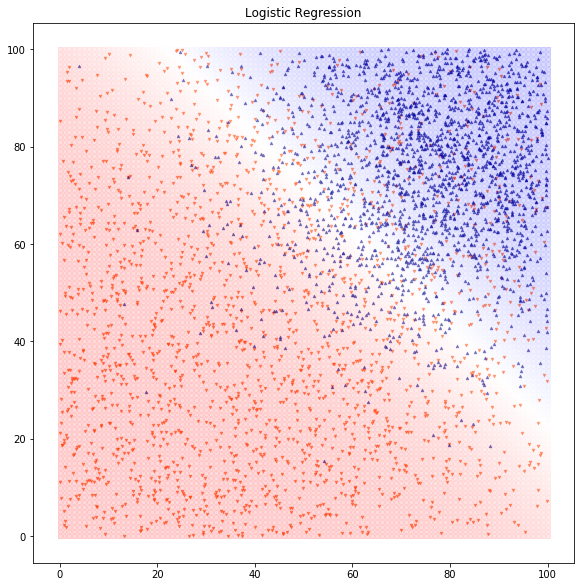

In [6]:
est = LogisticRegression(solver='lbfgs')
est.fit(X, y)
y_pred = est.predict(X)

print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
y_test_pred = est.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = est.predict_proba(X_pred)
Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Logistic Regression", bgsize=15)    

In [7]:
class_chart(class1_test, class2_test, Z, "Logistic Regression")    

0.06395235603484124 0.06439306478626172 -7.888679862607952


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in less



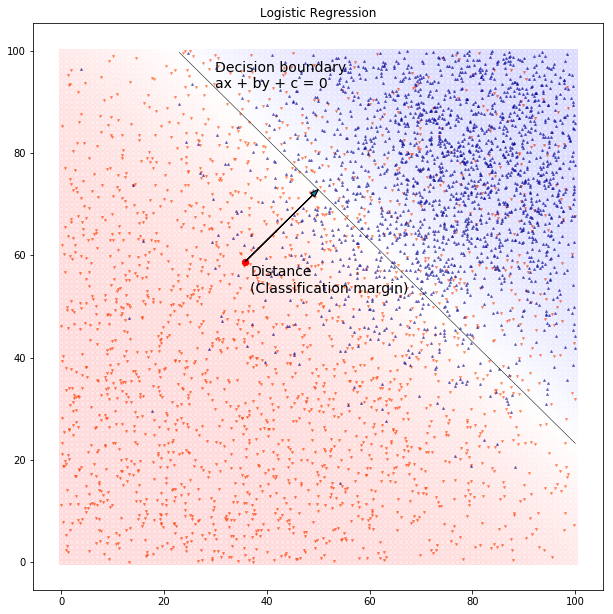

In [8]:
a, b = (est.coef_[0,0], est.coef_[0,1])
c = est.intercept_[0]
print(a,b,c)
my_x = np.linspace(0,100,101)
my_y = (-c - a * my_x)/b
my_y[my_y > 100.5] = np.nan
my_y[my_y < 0.5] = np.nan

dpi = 96
fig, widget = plt.subplots(figsize=(981/dpi,1001/dpi))
widget.scatter(class1_test[:,0], class1_test[:,1], s=4, c='orangered', marker='v', alpha=0.5)
widget.scatter(class2_test[:,0], class2_test[:,1], s=4, c='darkblue', marker='^', alpha=0.5)
widget.scatter(Z[:,0], Z[:,1], c=Z[:,2]-0.5, cmap="bwr", marker='s', s=17, alpha=0.1)
widget.plot(my_x, my_y, c='black', lw=0.5)
widget.set_title("Logistic Regression")

vec_xlength, vec_ylength = -b / np.sqrt(b**2 + a**2) *20, -a / np.sqrt(b**2 + a**2) *20
widget.arrow(my_x[50]+ vec_xlength, my_y[50] + vec_ylength, -vec_xlength, -vec_ylength, head_width=1, length_includes_head=True)
widget.scatter(x=my_x[50]+ vec_xlength, y=my_y[50]+vec_ylength, c='red', s=40, label='point')
widget.text(x=my_x[50]+ vec_xlength+1, y=my_y[50]+vec_ylength-6, s='Distance\n(Classification margin)', fontsize=14)
widget.text(x=my_x[30], y=my_y[30], s='Decision boundary\nax + by + c = 0', fontsize=14)

widget.arrow(my_x[50]+ vec_xlength, my_y[50] + vec_ylength, -vec_xlength, -vec_ylength, head_width=1, length_includes_head=True)


In [9]:
def class_chart_with_annotations(X1, X2, probas, title=""):
    
    trace1 = Scatter(
        x = X1[:,0],
        y = X1[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="orangered"
        )
    )

    trace2 = Scatter(
        x = X2[:,0],
        y = X2[:,1],
        mode = 'markers',
        marker = dict(
            size = 3,
            color="darkblue"
        )
    )
    data = [trace1, trace2]

    if probas is not None:
        trace3 = Scatter(
            x = probas[:,0],
            y = probas[:,1],
            mode = 'markers',
            marker = dict(
                size = 4,
                opacity = 0.5*abs(probas[:,2]-0.5),
                color = probas[:,2]-0.5,
                colorscale=[[0.0, 'rgb(165,0,38)'], 
                            [0.1111111111111111, 'rgb(215,48,39)'], 
                            [0.2222222222222222, 'rgb(244,109,67)'], 
                            [0.3333333333333333, 'rgb(253,174,97)'], 
                            [0.4444444444444444, 'rgb(254,224,144)'], 
                            [0.5555555555555556, 'rgb(224,243,248)'], 
                            [0.6666666666666666, 'rgb(171,217,233)'], 
                            [0.7777777777777778, 'rgb(116,173,209)'], 
                            [0.8888888888888888, 'rgb(69,117,180)'], 
                            [1.0, 'rgb(49,54,149)']],                
                symbol = 'square'
            )
        )
        
        data.append(trace3)

    trace4 = Scatter(
        x = my_x,
        y = my_y,
        mode = 'lines',
        line = dict(
            color = ('black'),
            width = 2)
    )        
    data.append(trace4)
        
    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=640,
        showlegend=False,
        xaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            range=[0, 100],
            linecolor='black',
            mirror=True
        ),
        annotations=[
            dict(
                x=my_x[70],
                y=my_y[70],
                xref='x',
                yref='y',
                text='Decision Boundary: ax + by + c = 0',
                showarrow=True,
                font=dict(
                    family='Arial, sans-serif',
                    size=16,
                    color='black'
                ),
                align='center',
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor='#333333',
                ax=-20,
                ay=60,
                bordercolor='#c7c7c7',
                borderwidth=2,
                borderpad=4,
                bgcolor='#ff7f0e',
                opacity=0.75
            ),
            dict(
                x=my_x[50],
                y=my_y[50],
                xref='x',
                yref='y',
                text='Distance to boundary',
                showarrow=True,
                font=dict(
                    family='Arial, sans-serif',
                    size=16,
                    color='black'
                ),
                align='center',
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor='#333333',
                ax=-vec_xlength*5,
                ay= vec_ylength*5,
                bordercolor='#c7c7c7',
                borderwidth=2,
                borderpad=4,
                bgcolor='#ff7f0e',
                opacity=0.75
            ),
            
        ]
    )        

    fig = Figure(data=data, layout=layout)

    return iplot(fig)

class_chart_with_annotations(class1, class2, Z, "Logistic Regression")

0.25
0.5
0.75


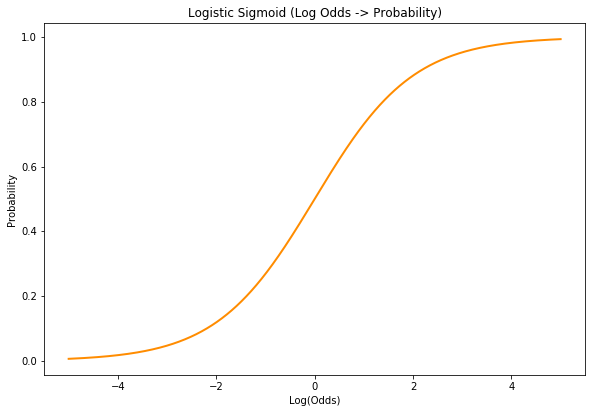

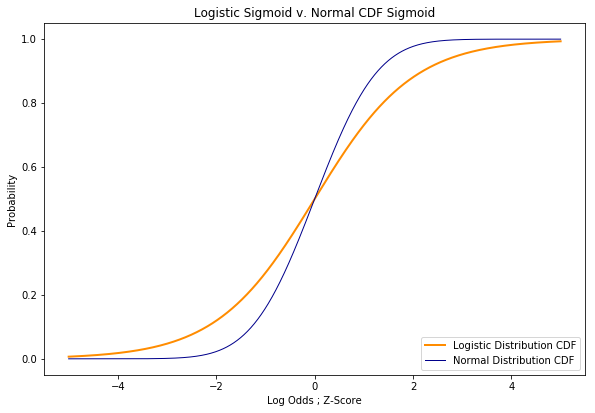

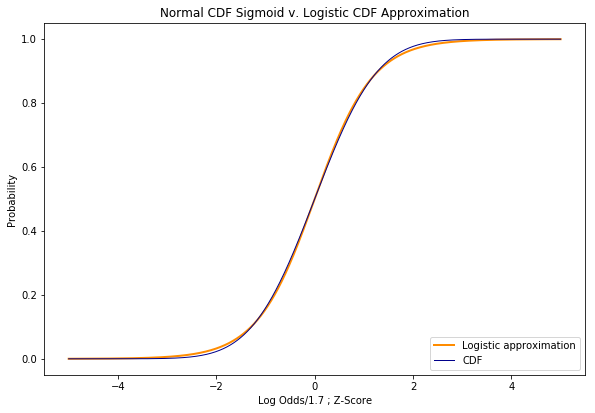

In [10]:
def logistic_sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

print(logistic_sigmoid(np.log(1/3)))
print(logistic_sigmoid(0))
print(logistic_sigmoid(np.log(3)))

x_dist = np.linspace(-5, 5, 1000)
y_logistic = logistic_sigmoid(x_dist)
y_logistic_approx = logistic_sigmoid(x_dist*1.7)
y_normcdf = norm.cdf(x_dist)

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic, lw=2, c='darkorange', alpha=1)
plt.ylabel('Probability')
plt.xlabel('Log(Odds)')
plt.title('Logistic Sigmoid (Log Odds -> Probability)')
plt.show()

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic, lw=2, c='darkorange', alpha=1, label = 'Logistic Distribution CDF')
plt.plot(x_dist, y_normcdf, lw=1, c='darkblue', alpha=1, label = 'Normal Distribution CDF')
plt.legend(loc="lower right")
plt.ylabel('Probability')
plt.xlabel('Log Odds ; Z-Score')
plt.title('Logistic Sigmoid v. Normal CDF Sigmoid')
plt.show()

plt.rcParams['text.usetex'] = 'false'
plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, y_logistic_approx, lw=2, c='darkorange', alpha=1, label = 'Logistic approximation')
plt.plot(x_dist, y_normcdf, lw=1, c='darkblue', alpha=1, label = 'CDF')
plt.legend(loc="lower right")
plt.ylabel('Probability')
plt.xlabel('Log Odds/1.7 ; Z-Score')
plt.title('Normal CDF Sigmoid v. Logistic CDF Approximation')
plt.show()

In [11]:
x_dist

array([-5.        , -4.98998999, -4.97997998, -4.96996997, -4.95995996,
       -4.94994995, -4.93993994, -4.92992993, -4.91991992, -4.90990991,
       -4.8998999 , -4.88988989, -4.87987988, -4.86986987, -4.85985986,
       -4.84984985, -4.83983984, -4.82982983, -4.81981982, -4.80980981,
       -4.7997998 , -4.78978979, -4.77977978, -4.76976977, -4.75975976,
       -4.74974975, -4.73973974, -4.72972973, -4.71971972, -4.70970971,
       -4.6996997 , -4.68968969, -4.67967968, -4.66966967, -4.65965966,
       -4.64964965, -4.63963964, -4.62962963, -4.61961962, -4.60960961,
       -4.5995996 , -4.58958959, -4.57957958, -4.56956957, -4.55955956,
       -4.54954955, -4.53953954, -4.52952953, -4.51951952, -4.50950951,
       -4.4994995 , -4.48948949, -4.47947948, -4.46946947, -4.45945946,
       -4.44944945, -4.43943944, -4.42942943, -4.41941942, -4.40940941,
       -4.3993994 , -4.38938939, -4.37937938, -4.36936937, -4.35935936,
       -4.34934935, -4.33933934, -4.32932933, -4.31931932, -4.30

In [12]:
def line_chart(x1, y1, title="", ytitle="", xtitle=""):
    
    trace1 = Scatter(
        x = x1,
        y = y1,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            dtick=0.1,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            dtick=1,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        )
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)

line_chart(x_dist, y_logistic, "Logistic Sigmoid", 'Probability', 'Log(Odds)')

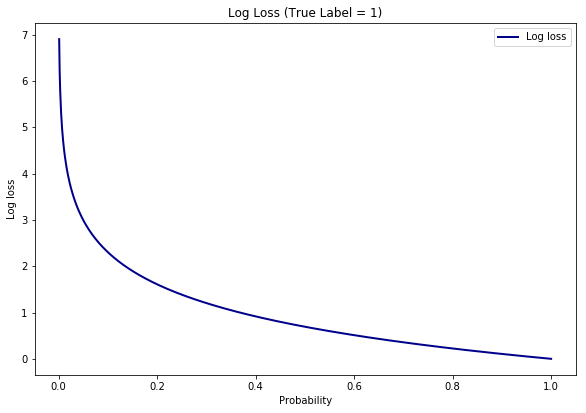

In [13]:
x_dist = np.linspace(0.001, 1, 1000)
log_loss = -np.log(x_dist)

plt.figure(figsize=(931/dpi,621/dpi))
plt.plot(x_dist, log_loss, lw=2, c='darkblue', alpha=1, label = 'Log loss')
plt.legend(loc="upper right")
plt.ylabel('Log loss')
plt.xlabel('Probability')
plt.title('Log Loss (True Label = 1)')
plt.show()

In [14]:
def line_chart(x1, y1, title="", ytitle="", xtitle=""):
    
    trace1 = Scatter(
        x = x1,
        y = y1,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            range=[0, 6],
            linecolor='black',
            mirror=True,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            linecolor='black',
            mirror=True,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        )
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)


line_chart(x_dist, log_loss, "Log Loss (True Label = 1)", 'Log Loss', 'Predicted Probability')

[[50 50]]
[[0.81327143 0.18672857]]
[0.]
[-1.47140882]
[0.18672857]
AUC: 0.9157


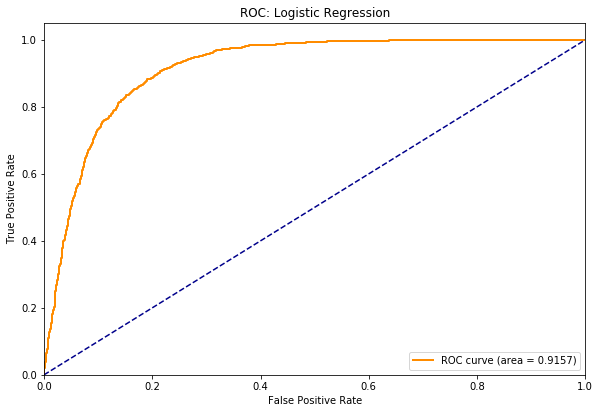

0.9156884999999999

In [15]:
# ROC curve

XX = np.array([50,  50]).reshape(1,2)
print(XX)
print(est.predict_proba(XX))
print(est.predict(XX))
print(est.decision_function(XX))
print(1 / (1 + np.exp(-est.decision_function(XX))))

def roc_chart(est, X_test, y_test, title):
    y_pred_prob = est.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_val = auc(fpr, tpr)
    print("AUC: %.4f" % auc_val)
    
    plt.figure(figsize=(931/dpi,621/dpi))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return auc_val

roc_chart(est, X_test, y_test, "ROC: Logistic Regression")

In [16]:
def plotly_roc_chart(est, X_test, y_test, title="", ytitle="", xtitle=""):
    y_pred_prob = est.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_val = auc(fpr, tpr)
    print("AUC: %.4f" % auc_val)
    
    trace1 = Scatter(
        x = fpr,
        y = tpr,
        mode = 'lines',
    )

    data = [trace1]

    layout = Layout(
        title = title,
        autosize=False,
        width=640,
        height=480,
        showlegend=False,
        yaxis=dict(
            linecolor='black',
            mirror=True,
            title=ytitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey',
            ),
        ),
        xaxis=dict(
            linecolor='black',
            mirror=True,
            title=xtitle,
            titlefont=dict(
                family='Arial, sans-serif',
                size=15,
                color='grey'
            ),        
        ),
        annotations=[
            dict(
                x=0.9,
                y=0.05,
                text="AUC: %.4f" % auc_val,
                showarrow=False,
        )
    ]        
    )
    fig = Figure(data=data, layout=layout)

    return iplot(fig)


plotly_roc_chart(est, X_test, y_test, "ROC: Logistic Regression", "True Positive Rate", "False Positive Rate")

AUC: 0.9157


In [17]:
y_pred_prob = est.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
for thresh in thresholds:
    my_y_pred = y_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
    f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
    print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

def select_threshold(y_test, y_pred_prob, metric_fn):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    metric_list = []
    for i, thresh in enumerate(thresholds):
        my_y_pred = y_pred_prob > thresh
        metric = metric_fn(y_test, my_y_pred)
        metric_list.append(metric)
    return thresholds[np.argmax(metric_list)]

print("")
thresh = select_threshold(y_test, y_pred_prob, sklearn.metrics.accuracy_score)
my_y_pred = y_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

print("")
thresh = select_threshold(y_test, y_pred_prob, sklearn.metrics.f1_score)
my_y_pred = y_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_test, my_y_pred)
f1_score = sklearn.metrics.f1_score(y_test, my_y_pred)
print("Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))



Threshold 1.9917 Accuracy 0.5000 F1 0.0000
Threshold 0.9917 Accuracy 0.5000 F1 0.0000
Threshold 0.9914 Accuracy 0.5002 F1 0.0010
Threshold 0.9878 Accuracy 0.5055 F1 0.0227
Threshold 0.9878 Accuracy 0.5058 F1 0.0237
Threshold 0.9850 Accuracy 0.5095 F1 0.0392
Threshold 0.9849 Accuracy 0.5098 F1 0.0401
Threshold 0.9807 Accuracy 0.5198 F1 0.0787
Threshold 0.9806 Accuracy 0.5200 F1 0.0796
Threshold 0.9806 Accuracy 0.5198 F1 0.0795
Threshold 0.9805 Accuracy 0.5200 F1 0.0805
Threshold 0.9803 Accuracy 0.5208 F1 0.0841
Threshold 0.9803 Accuracy 0.5210 F1 0.0850
Threshold 0.9722 Accuracy 0.5427 F1 0.1622
Threshold 0.9722 Accuracy 0.5430 F1 0.1630
Threshold 0.9708 Accuracy 0.5453 F1 0.1713
Threshold 0.9708 Accuracy 0.5455 F1 0.1721
Threshold 0.9694 Accuracy 0.5493 F1 0.1853
Threshold 0.9694 Accuracy 0.5495 F1 0.1861
Threshold 0.9659 Accuracy 0.5587 F1 0.2166
Threshold 0.9659 Accuracy 0.5590 F1 0.2174
Threshold 0.9637 Accuracy 0.5653 F1 0.2376
Threshold 0.9635 Accuracy 0.5655 F1 0.2384
Threshold 0

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



Threshold 0.9217 Accuracy 0.6358 F1 0.4487
Threshold 0.9211 Accuracy 0.6368 F1 0.4515
Threshold 0.9210 Accuracy 0.6370 F1 0.4521
Threshold 0.9197 Accuracy 0.6395 F1 0.4583
Threshold 0.9195 Accuracy 0.6395 F1 0.4587
Threshold 0.9161 Accuracy 0.6475 F1 0.4774
Threshold 0.9160 Accuracy 0.6478 F1 0.4780
Threshold 0.9152 Accuracy 0.6485 F1 0.4800
Threshold 0.9152 Accuracy 0.6488 F1 0.4806
Threshold 0.9133 Accuracy 0.6525 F1 0.4893
Threshold 0.9133 Accuracy 0.6528 F1 0.4899
Threshold 0.9131 Accuracy 0.6530 F1 0.4908
Threshold 0.9128 Accuracy 0.6532 F1 0.4914
Threshold 0.9112 Accuracy 0.6562 F1 0.4984
Threshold 0.9111 Accuracy 0.6565 F1 0.4989
Threshold 0.9105 Accuracy 0.6567 F1 0.4998
Threshold 0.9101 Accuracy 0.6570 F1 0.5004
Threshold 0.9095 Accuracy 0.6575 F1 0.5018
Threshold 0.9095 Accuracy 0.6577 F1 0.5024
Threshold 0.9093 Accuracy 0.6577 F1 0.5027
Threshold 0.9092 Accuracy 0.6580 F1 0.5033
Threshold 0.9079 Accuracy 0.6603 F1 0.5085
Threshold 0.9079 Accuracy 0.6605 F1 0.5090
Threshold 0

Threshold 0.7483 Accuracy 0.7847 F1 0.7544
Threshold 0.7467 Accuracy 0.7855 F1 0.7556
Threshold 0.7465 Accuracy 0.7857 F1 0.7559
Threshold 0.7459 Accuracy 0.7857 F1 0.7560
Threshold 0.7459 Accuracy 0.7860 F1 0.7564
Threshold 0.7448 Accuracy 0.7860 F1 0.7565
Threshold 0.7439 Accuracy 0.7857 F1 0.7565
Threshold 0.7434 Accuracy 0.7855 F1 0.7562
Threshold 0.7431 Accuracy 0.7857 F1 0.7566
Threshold 0.7430 Accuracy 0.7855 F1 0.7564
Threshold 0.7415 Accuracy 0.7853 F1 0.7563
Threshold 0.7370 Accuracy 0.7885 F1 0.7610
Threshold 0.7369 Accuracy 0.7887 F1 0.7614
Threshold 0.7363 Accuracy 0.7887 F1 0.7615
Threshold 0.7357 Accuracy 0.7887 F1 0.7616
Threshold 0.7348 Accuracy 0.7890 F1 0.7621
Threshold 0.7346 Accuracy 0.7893 F1 0.7625
Threshold 0.7326 Accuracy 0.7905 F1 0.7643
Threshold 0.7320 Accuracy 0.7907 F1 0.7647
Threshold 0.7305 Accuracy 0.7930 F1 0.7679
Threshold 0.7297 Accuracy 0.7927 F1 0.7679
Threshold 0.7290 Accuracy 0.7930 F1 0.7683
Threshold 0.7288 Accuracy 0.7933 F1 0.7687
Threshold 0

Threshold 0.5141 Accuracy 0.8433 F1 0.8464
Threshold 0.5120 Accuracy 0.8433 F1 0.8465
Threshold 0.5118 Accuracy 0.8435 F1 0.8468
Threshold 0.5111 Accuracy 0.8433 F1 0.8466
Threshold 0.5111 Accuracy 0.8435 F1 0.8469
Threshold 0.5111 Accuracy 0.8433 F1 0.8467
Threshold 0.5105 Accuracy 0.8435 F1 0.8469
Threshold 0.5103 Accuracy 0.8433 F1 0.8467
Threshold 0.5087 Accuracy 0.8430 F1 0.8466
Threshold 0.5083 Accuracy 0.8430 F1 0.8467
Threshold 0.5067 Accuracy 0.8427 F1 0.8465
Threshold 0.5062 Accuracy 0.8425 F1 0.8463
Threshold 0.5059 Accuracy 0.8427 F1 0.8466
Threshold 0.5056 Accuracy 0.8425 F1 0.8464
Threshold 0.5043 Accuracy 0.8427 F1 0.8467
Threshold 0.5031 Accuracy 0.8425 F1 0.8465
Threshold 0.5027 Accuracy 0.8427 F1 0.8468
Threshold 0.4998 Accuracy 0.8433 F1 0.8474
Threshold 0.4991 Accuracy 0.8430 F1 0.8473
Threshold 0.4963 Accuracy 0.8430 F1 0.8474
Threshold 0.4963 Accuracy 0.8433 F1 0.8476
Threshold 0.4950 Accuracy 0.8435 F1 0.8480
Threshold 0.4949 Accuracy 0.8438 F1 0.8483
Threshold 0

Threshold 0.2410 Accuracy 0.8250 F1 0.8469
Threshold 0.2402 Accuracy 0.8247 F1 0.8467
Threshold 0.2390 Accuracy 0.8245 F1 0.8466
Threshold 0.2387 Accuracy 0.8245 F1 0.8467
Threshold 0.2387 Accuracy 0.8247 F1 0.8469
Threshold 0.2381 Accuracy 0.8245 F1 0.8467
Threshold 0.2372 Accuracy 0.8243 F1 0.8466
Threshold 0.2368 Accuracy 0.8240 F1 0.8464
Threshold 0.2327 Accuracy 0.8225 F1 0.8454
Threshold 0.2324 Accuracy 0.8223 F1 0.8452
Threshold 0.2291 Accuracy 0.8213 F1 0.8445
Threshold 0.2281 Accuracy 0.8213 F1 0.8446
Threshold 0.2230 Accuracy 0.8193 F1 0.8432
Threshold 0.2222 Accuracy 0.8190 F1 0.8430
Threshold 0.2213 Accuracy 0.8187 F1 0.8429
Threshold 0.2212 Accuracy 0.8185 F1 0.8427
Threshold 0.2203 Accuracy 0.8185 F1 0.8428
Threshold 0.2173 Accuracy 0.8190 F1 0.8434
Threshold 0.2154 Accuracy 0.8180 F1 0.8427
Threshold 0.2153 Accuracy 0.8177 F1 0.8425
Threshold 0.2120 Accuracy 0.8173 F1 0.8422
Threshold 0.2120 Accuracy 0.8170 F1 0.8420
Threshold 0.2106 Accuracy 0.8170 F1 0.8421
Threshold 0

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



Threshold 0.3867 Accuracy 0.8440 F1 0.8555


In-Sample Accuracy (50% threshold): 0.8433


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



CV Threshold 0.4236 Accuracy 0.8475 F1 0.8562
Out-Of-Sample Accuracy: 0.8442
Confusion Matrix:
[[1581  419]
 [ 204 1796]]
(True negative 1581 True positive 1796 False positive 204 False negative 419)
              precision    recall  f1-score   support

         0.0     0.8857    0.7905    0.8354      2000
         1.0     0.8108    0.8980    0.8522      2000

   micro avg     0.8442    0.8442    0.8443      4000
   macro avg     0.8483    0.8442    0.8438      4000
weighted avg     0.8483    0.8442    0.8438      4000

AUC: 0.9157


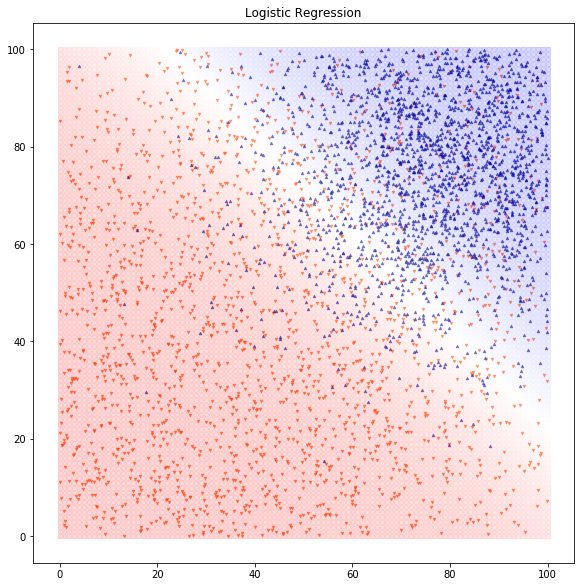

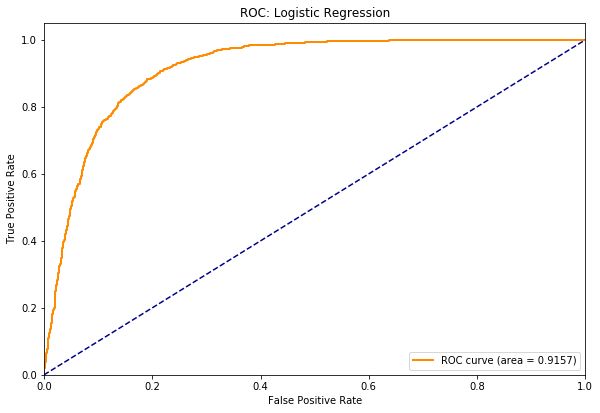

0.915686

In [18]:
# Template for binary classification with training, CV, and test sets

estimator = LogisticRegression
est = estimator()
est.fit(X, y)
y_pred = est.predict(X)
print("In-Sample Accuracy (50%% threshold): %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
# select threshold using CV data to maximize accuracy
y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
y_cv_pred = y_cv_pred_prob > thresh
acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

# evaluate estimator using test data
y_test_pred_prob = est.predict_proba(X_test)[:,1]
y_test_pred = y_test_pred_prob > thresh
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, digits=4))

z = est.predict_proba(X_pred)
Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Logistic Regression", bgsize=15)   
roc_chart(est, X_test, y_test, "ROC: Logistic Regression")


In [19]:
# list all classifiers that support predict_proba 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)
estimators

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.naive_bayes.ComplementNB'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_netwo

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.naive_bayes.ComplementNB,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.Quadrati

In [33]:
# Wrappers for some non-sklearn models 
# and some sklearn models that need custom params

def myNuSVC():
    # needs probability=True
    return sklearn.svm.classes.NuSVC(probability=True)

def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log", max_iter=1000, tol=1e-4)

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

def myLGBMClassifier():
    def create_model():
        return lgb.LGBMClassifier(silent=True)
    return create_model

# statsmodels use a different interface from sklearn and I don't see a wrapper, so here's a wrapper
class SMwrapper:
    def __init__(self, smclass):
        self.smclass = smclass
        self.model=None
        self.result=None

    def fit(self, X, y_class):
        # statsmodels need an explicit intercept
        intercept = np.array([1] * len(X)).reshape(len(X),1)
        X = np.hstack([X,intercept])
        self.model = self.smclass(y_class, X)
        self.result = self.model.fit()
        
    def predict_proba(self, X_pred):
        intercept = np.array([1] * len(X_pred)).reshape(len(X_pred),1)
        X_pred = np.hstack([X_pred,intercept])
        self.y_pred_proba = self.result.predict(X_pred)
        retarray = np.array([1-self.y_pred_proba, self.y_pred_proba]).T        
        return retarray

    def predict(self, X_pred):
        intercept = np.array([1] * len(X_pred)).reshape(len(X_pred),1)
        X_pred = np.hstack([X_pred,intercept])
        self.y_pred_proba = self.result.predict(X_pred)
        #print("median %f" % np.median(self.y_pred_proba))
        #y_pred = self.y_pred_proba > np.median(self.y_pred_proba)
        y_pred = self.y_pred_proba > 0.5
        return y_pred
    
def statsmodels_wrapper(smclass):
    def create_smwrapper():
        return SMwrapper(smclass)
    return create_smwrapper

EPOCHS=1000
INPUT_DIM=2
def myKerasClassifier(n_hidden_layers = 1,
                      hidden_layer_size = 16,
                      reg_penalty = 0.01,
                      epochs=EPOCHS,
                      verbose=True):
    
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        output = Dense(1, activation='sigmoid')(lastlayer)            
        model = Model(inputs=[main_input], outputs=[output])
        if verbose:
            print(model.summary())

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
    
def modelFactory(n_hidden_layers = 1,
                 hidden_layer_size = 16,
                 reg_penalty = 0.01,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return myKerasClassifier(n_hidden_layers,
                                 hidden_layer_size,
                                 reg_penalty,
                                 epochs,
                                 verbose)
    return create_fn

# KerasClassifier wraps a Keras model with an sklearn interface
# But it returns wrong shape for VotingClassifier ensemble
# 2D shape (nrows,1) instead of 1D (nrows) 
# Subclass KerasClassifier and override predict  

class monkeyKerasClassifier(KerasClassifier):
    """subclass KerasClassifier and override predict to work with VotingClassifier"""
    def __init__(self, *args, **kwargs):
        super(KerasClassifier, self).__init__(*args, **kwargs)        
        
    def predict(self, x, **kwargs):
        # this should work but nope
        # pred = KerasClassifier.predict(self, x, **kwargs)
        # return pred[:, 0]
        
        pred = self.model.predict(x, **kwargs)
        return np.round(pred[:,0])        

    def predict_proba(self, x, **kwargs):
        pred = self.model.predict(x, **kwargs)
        return np.vstack([1-pred[:,0], pred[:,0]]).T
    
def kerasClassifierFactory(n_hidden_layers = 1,
                           hidden_layer_size = 16,
                           reg_penalty = 0.01,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return monkeyKerasClassifier(build_fn=modelFactory(n_hidden_layers,
                                                     hidden_layer_size,
                                                     reg_penalty,
                                                     epochs,
                                                     verbose), 
                               epochs=EPOCHS, 
                               batch_size=100, 
                               verbose=0)
    return create_fn


layer 1 size 16, reg_penalty 0.01000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
In-Sample Accuracy: 0.8495
Out-Of-Sample Accuracy: 0.8572
Confusion Matrix:
[[1563  437]
 [ 134 1866]]
(True negative 1563 True positive 1866 False positive 134 False negative 437)
AUC: 0.9232


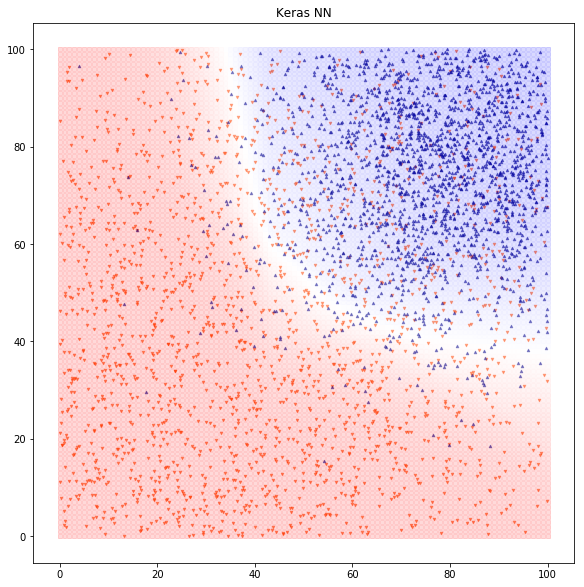

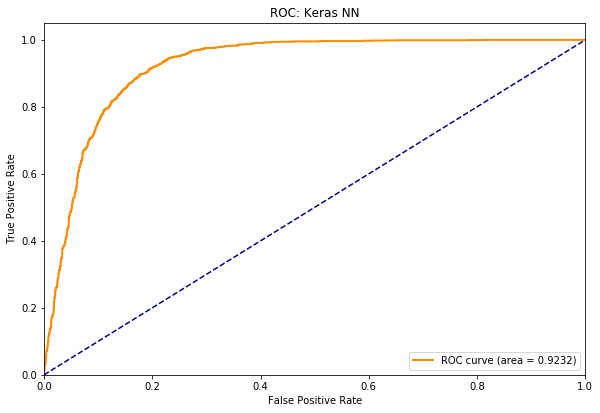

0.9231788750000001

In [34]:
model = kerasClassifierFactory()()
#print(dir(model))
model.fit(X,y)

y_pred = model.predict(X)
print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
y_test_pred = model.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = model.predict_proba(X_pred)
if len(z.shape) == 1:
    z = z.reshape(z.shape[0], 1)

Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "Keras NN", bgsize=15)    
roc_chart(model, X_test, y_test, "ROC: Keras NN")

In [ ]:
# cross-validate a bunch of keras models
n_layers = [1, 2, 3]
hidden_layer_sizes = [4, 8, 16, 32, 64]
reg_penaltys = [0, 0.0001, 0.001, 0.01, 0.1]

hyperparameter_combos = list(product(n_layers, hidden_layer_sizes, reg_penaltys))

keys = []
accuracies= []
aucs = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, hidden_layer_size, reg_penalty = param_list
    est = kerasClassifierFactory(n_hidden_layers=n_hidden_layers,
                                   hidden_layer_size=hidden_layer_size,
                                   reg_penalty=reg_penalty)()

    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, hidden_layer_size, reg_penalty)
    print(key)
    keys.append(key)
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    y_test_pred = est.predict(X_test)
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    accuracies.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    estname="Keras NN %d layers, %d units %f reg_penalty" % (n_hidden_layers, hidden_layer_size, reg_penalty)
    class_chart_matplotlib(class1_test, class2_test, Z, estname, bgsize=15)    
    myauc = roc_chart(est, X_test, y_test, "ROC: %s" % estname)
    aucs.append(myauc)
    print()
    print('############################################################')
    print()
    

In [23]:
#make dataframe
flatlist = []
for k, acc, myauc in zip(keys, accuracies, aucs):
    flatlist.append([k[0], k[1], k[2], acc, myauc, acc+myauc])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'units', 'reg_penalty', 'acc', 'auc', 'comb'])

#sort by auc + accuracy
metricsframe.sort_values(['comb'], ascending=False)
#heatmap

layers  units  reg_penalty      acc       auc      comb
8        1      8       0.0100  0.86175  0.923929  1.785678
57       3      8       0.0010  0.86075  0.923926  1.784676
18       1     32       0.0100  0.86050  0.923886  1.784386
30       2      8       0.0000  0.86025  0.923415  1.783665
15       1     32       0.0000  0.85950  0.923956  1.783457
65       3     32       0.0000  0.85975  0.923455  1.783205
48       2     64       0.0100  0.86000  0.923167  1.783167
66       3     32       0.0001  0.85950  0.923615  1.783115
43       2     32       0.0100  0.86025  0.922697  1.782946
42       2     32       0.0010  0.85950  0.923418  1.782918
13       1     16       0.0100  0.85875  0.924124  1.782874
40       2     32       0.0000  0.85950  0.923361  1.782861
31       2      8       0.0001  0.85900  0.923857  1.782857
37       2     16       0.0010  0.85900  0.923662  1.782662
71       3     64       0.0001  0.85900  0.923586  1.782586
60       3     16       0.0000  0.85875  0.923665  1.782415
6        1      8       0.0001  0.85850  0.923658  1.782158
67       3     32       0.0010  0.85850  0.923580  1.782080
68       3     32       0.0100  0.85875  0.923208  1.781958
61       3     16       0.0001  0.85850  0.923451  1.781951
11       1     16       0.0001  0.85875  0.923196  1.781947
72       3     64       0.0010  0.85825  0.923695  1.781945
38       2     16       0.0100  0.85825  0.923692  1.781942
73       3     64       0.0100  0.85875  0.923026  1.781776
35       2     16       0.0000  0.85800  0.923762  1.781762
51       3      4       0.0001  0.85825  0.923457  1.781707
34       2      8       0.1000  0.85925  0.922367  1.781617
22       1     64       0.0010  0.85775  0.923793  1.781543
53       3      4       0.0100  0.85800  0.923532  1.781532
50       3      4       0.0000  0.85850  0.923030  1.781531
..     ...    ...          ...      ...       ...       ...
70       3     64       0.0000  0.85675  0.923663  1.780413
20       1     64       0.0000  0.85675  0.923625  1.780375
45       2     64       0.0000  0.85700  0.923317  1.780317
17       1     32       0.0010  0.85700  0.923135  1.780135
62       3     16       0.0010  0.85650  0.923584  1.780084
9        1      8       0.1000  0.85700  0.922793  1.779793
63       3     16       0.0100  0.85700  0.922783  1.779783
16       1     32       0.0001  0.85600  0.923756  1.779756
52       3      4       0.0010  0.85650  0.922903  1.779403
58       3      8       0.0100  0.85850  0.920493  1.778993
55       3      8       0.0000  0.85575  0.922681  1.778431
0        1      4       0.0000  0.85550  0.922845  1.778345
4        1      4       0.1000  0.85700  0.920912  1.777912
19       1     32       0.1000  0.85600  0.921640  1.777640
27       2      4       0.0010  0.85475  0.922805  1.777554
23       1     64       0.0100  0.85450  0.922744  1.777244
28       2      4       0.0100  0.85375  0.922865  1.776615
24       1     64       0.1000  0.85250  0.919755  1.772255
3        1      4       0.0100  0.84600  0.920668  1.766668
69       3     32       0.1000  0.84350  0.915683  1.759183
54       3      4       0.1000  0.84325  0.915685  1.758935
74       3     64       0.1000  0.84300  0.915681  1.758681
49       2     64       0.1000  0.84250  0.915710  1.758210
39       2     16       0.1000  0.84250  0.915685  1.758185
59       3      8       0.1000  0.84250  0.915685  1.758185
64       3     16       0.1000  0.84225  0.915694  1.757944
1        1      4       0.0001  0.84225  0.915682  1.757932
44       2     32       0.1000  0.84225  0.915664  1.757914
29       2      4       0.1000  0.84225  0.915412  1.757662
7        1      8       0.0010  0.84025  0.915537  1.755787

[75 rows x 6 columns]

In [24]:
#summarize average by layers, units, reg_penalty

pd.DataFrame(metricsframe.groupby(['layers'])[['acc', 'auc', 'comb']].mean())

acc       auc      comb
layers                             
1       0.85582  0.922261  1.778081
2       0.85559  0.922038  1.777628
3       0.85514  0.921734  1.776874

In [25]:
pd.DataFrame(metricsframe.groupby(['units'])[['acc', 'auc', 'comb']].mean())

acc       auc      comb
units                              
4      0.853383  0.921220  1.774603
8      0.856317  0.922085  1.778401
16     0.856050  0.922334  1.778384
32     0.856550  0.922292  1.778842
64     0.855283  0.922122  1.777406

In [26]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['acc', 'auc', 'comb']].mean())

acc       auc      comb
reg_penalty                              
0.0000       0.857967  0.923336  1.781303
0.0001       0.857067  0.922921  1.779987
0.0010       0.856700  0.922819  1.779519
0.0100       0.857483  0.922970  1.780454
0.1000       0.848367  0.918008  1.766375

In [27]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['comb'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
#                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(metricsframe, "layers", "units", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "units", x_suffix=" p", y_suffix="units")

In [ ]:
estimators = [sklearn.linear_model.logistic.LogisticRegression,
              sklearn.linear_model.logistic.LogisticRegressionCV,
              sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
              statsmodels_wrapper(statsmodels.discrete.discrete_model.Logit),
              statsmodels_wrapper(statsmodels.discrete.discrete_model.Probit),
              sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
              sklearn.neural_network.multilayer_perceptron.MLPClassifier,
              sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
              myXGBClassifier(),
              myCatBoostClassifier(),
              myLGBMClassifier(),
              sklearn.ensemble.weight_boosting.AdaBoostClassifier,
              sklearn.ensemble.bagging.BaggingClassifier,
              sklearn.tree.tree.DecisionTreeClassifier,
              sklearn.ensemble.forest.RandomForestClassifier,
              sklearn.tree.tree.ExtraTreeClassifier,
              sklearn.ensemble.forest.ExtraTreesClassifier,
              sklearn.naive_bayes.BernoulliNB,
              sklearn.calibration.CalibratedClassifierCV,
              sklearn.naive_bayes.GaussianNB,
              sklearn.gaussian_process.gpc.GaussianProcessClassifier,
              sklearn.neighbors.classification.KNeighborsClassifier,
              sklearn.semi_supervised.label_propagation.LabelPropagation,
              sklearn.semi_supervised.label_propagation.LabelSpreading,
              sklearn.naive_bayes.MultinomialNB,
              myNuSVC,
              mySGDClassifierLog,
              mySVC,
              kerasClassifierFactory(),
             ]

est_names=[]
for estimator in estimators:
    # fit 
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print('############################################################')
    print(estname)  
    print('############################################################')
    est_names.append(estname)
    est = estimator()
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    # select threshold using CV data to maximize accuracy
    y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
    thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
    y_cv_pred = y_cv_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
    f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
    print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

    # evaluate estimator using test data
    y_test_pred_prob = est.predict_proba(X_test)[:,1]
    y_test_pred = y_test_pred_prob > thresh
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    class_chart_matplotlib(class1_test, class2_test, Z, estname, bgsize=15)   
    try: # sometimes got nans
        roc_chart(est, X_test, y_test, "ROC: %s" % estname)
    except:
        pass
    print()


############################################################
LogisticRegression
In-Sample Accuracy: 0.8433


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



CV Threshold 0.4236 Accuracy 0.8475 F1 0.8562
Out-Of-Sample Accuracy: 0.8442
Confusion Matrix:
[[1581  419]
 [ 204 1796]]
(True negative 1581 True positive 1796 False positive 204 False negative 419)
############################################################

############################################################
LogisticRegressionCV
In-Sample Accuracy: 0.8433


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



CV Threshold 0.4220 Accuracy 0.8475 F1 0.8562
Out-Of-Sample Accuracy: 0.8442
Confusion Matrix:
[[1581  419]
 [ 204 1796]]
(True negative 1581 True positive 1796 False positive 204 False negative 419)
############################################################

############################################################
LinearDiscriminantAnalysis
In-Sample Accuracy: 0.8450
CV Threshold 0.4902 Accuracy 0.8475 F1 0.8562
Out-Of-Sample Accuracy: 0.8445
Confusion Matrix:
[[1581  419]
 [ 203 1797]]
(True negative 1581 True positive 1797 False positive 203 False negative 419)
############################################################

############################################################
Logit
Optimization terminated successfully.
         Current function value: 0.360994
         Iterations 7
In-Sample Accuracy: 0.8430
CV Threshold 0.4125 Accuracy 0.8475 F1 0.8561
Out-Of-Sample Accuracy: 0.8442
Confusion Matrix:
[[1581  419]
 [ 204 1796]]
(True negative 1581 True positive 1796 Fals

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In-Sample Accuracy: 0.8448
CV Threshold 0.4308 Accuracy 0.8465 F1 0.8541
Out-Of-Sample Accuracy: 0.8417
Confusion Matrix:
[[1593  407]
 [ 226 1774]]
(True negative 1593 True positive 1774 False positive 226 False negative 407)
############################################################

############################################################
SGDClassifier
In-Sample Accuracy: 0.8365
CV Threshold 1.0000 Accuracy 0.8417 F1 0.8543
Out-Of-Sample Accuracy: 0.8420
Confusion Matrix:
[[1520  480]
 [ 152 1848]]
(True negative 1520 True positive 1848 False positive 152 False negative 480)
############################################################

############################################################
QuadraticDiscriminantAnalysis
In-Sample Accuracy: 0.8538
CV Threshold 0.4286 Accuracy 0.8608 F1 0.8677
Out-Of-Sample Accuracy: 0.8598
Confusion Matrix:
[[1626  374]
 [ 187 1813]]
(True negative 1626 True positive 1813 False positive 187 False negative 374)
#############################

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Out-Of-Sample Accuracy: 0.8320
Confusion Matrix:
[[1542  458]
 [ 214 1786]]
(True negative 1542 True positive 1786 False positive 214 False negative 458)
############################################################

############################################################
BaggingClassifier
In-Sample Accuracy: 0.9878
CV Threshold 0.4000 Accuracy 0.8353 F1 0.8425
Out-Of-Sample Accuracy: 0.8280
Confusion Matrix:
[[1593  407]
 [ 281 1719]]
(True negative 1593 True positive 1719 False positive 281 False negative 407)
############################################################

############################################################
GradientBoostingClassifier
In-Sample Accuracy: 0.8655
CV Threshold 0.5113 Accuracy 0.8558 F1 0.8631
Out-Of-Sample Accuracy: 0.8550
Confusion Matrix:
[[1624  376]
 [ 204 1796]]
(True negative 1624 True positive 1796 False positive 204 False negative 376)
############################################################

#######################################

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



In-Sample Accuracy: 0.9183
CV Threshold 0.5009 Accuracy 0.8403 F1 0.8469
Out-Of-Sample Accuracy: 0.8357
Confusion Matrix:
[[1615  385]
 [ 272 1728]]
(True negative 1615 True positive 1728 False positive 272 False negative 385)
############################################################

############################################################
KNeighborsClassifier
In-Sample Accuracy: 0.8782
CV Threshold 0.2000 Accuracy 0.8393 F1 0.8553
Out-Of-Sample Accuracy: 0.8383
Confusion Matrix:
[[1479  521]
 [ 126 1874]]
(True negative 1479 True positive 1874 False positive 126 False negative 521)
############################################################

############################################################
LabelPropagation
In-Sample Accuracy: 0.9992
CV Threshold 0.0000 Accuracy 0.8297 F1 0.8449
Out-Of-Sample Accuracy: 0.8237
Confusion Matrix:
[[1482  518]
 [ 187 1813]]
(True negative 1482 True positive 1813 False positive 187 False negative 518)
###################################

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In-Sample Accuracy: 0.9153
CV Threshold 0.2996 Accuracy 0.8397 F1 0.8476
Out-Of-Sample Accuracy: 0.8347
Confusion Matrix:
[[1598  402]
 [ 259 1741]]
(True negative 1598 True positive 1741 False positive 259 False negative 402)
############################################################

############################################################
SVC


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In-Sample Accuracy: 0.9160
CV Threshold 0.3143 Accuracy 0.8395 F1 0.8474
Out-Of-Sample Accuracy: 0.8347
Confusion Matrix:
[[1597  403]
 [ 258 1742]]
(True negative 1597 True positive 1742 False positive 258 False negative 403)
############################################################



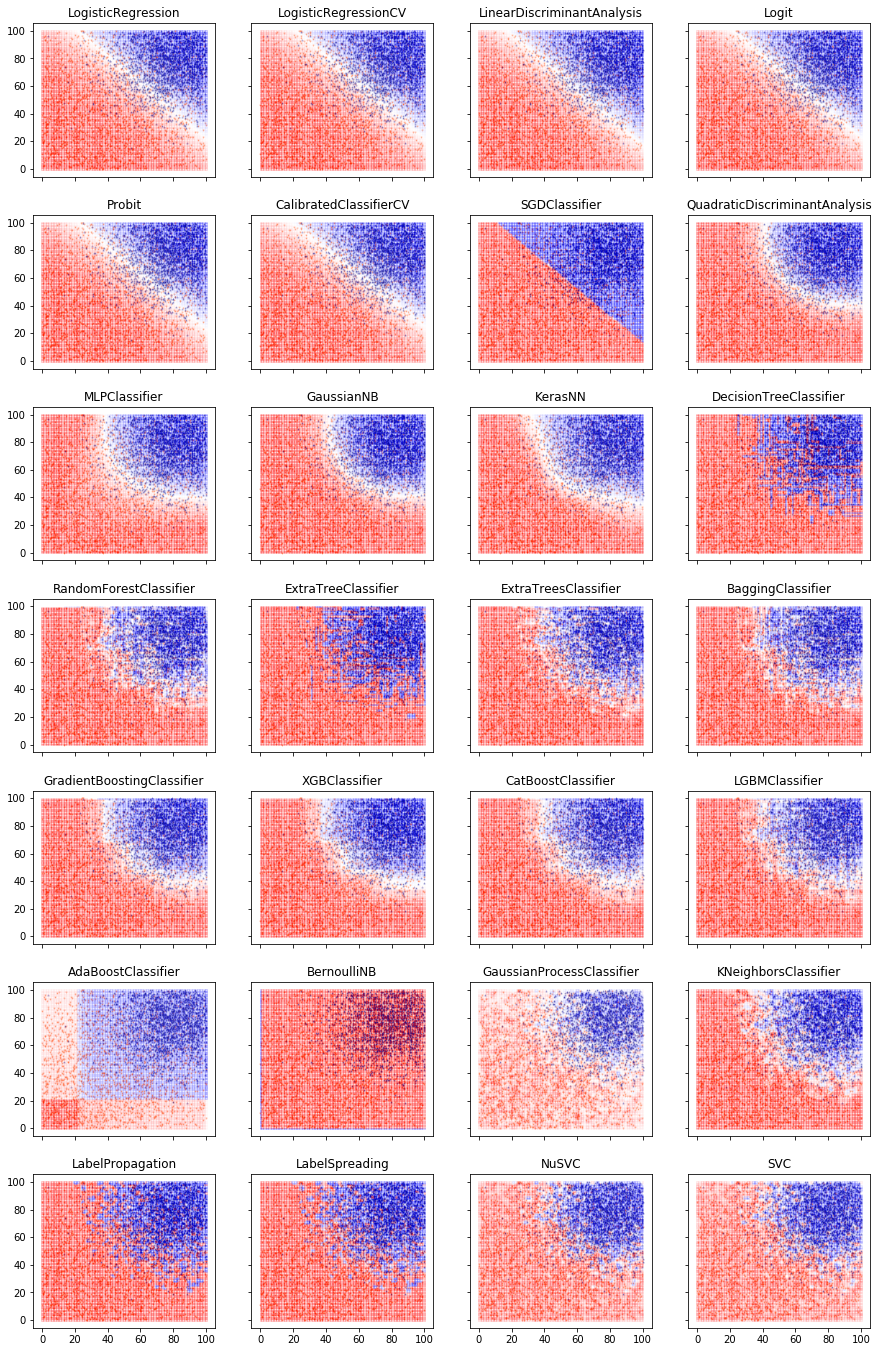

In [29]:
# same in grid

estimator_list = [('LogisticRegression', sklearn.linear_model.logistic.LogisticRegression),
                  ('LogisticRegressionCV', sklearn.linear_model.logistic.LogisticRegressionCV),
                  ('LinearDiscriminantAnalysis', sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
                  ('Logit', statsmodels_wrapper(statsmodels.discrete.discrete_model.Logit)),
                  ('Probit', statsmodels_wrapper(statsmodels.discrete.discrete_model.Probit)),
                  ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
                  ('SGDClassifier', mySGDClassifierLog),
                  ('QuadraticDiscriminantAnalysis', sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
                  ('MLPClassifier', sklearn.neural_network.multilayer_perceptron.MLPClassifier),
                  ('GaussianNB', sklearn.naive_bayes.GaussianNB),
                  ('KerasNN', kerasClassifierFactory()),
                  ('DecisionTreeClassifier', sklearn.tree.tree.DecisionTreeClassifier),
                  ('RandomForestClassifier', sklearn.ensemble.forest.RandomForestClassifier),
                  ('ExtraTreeClassifier', sklearn.tree.tree.ExtraTreeClassifier),
                  ('ExtraTreesClassifier', sklearn.ensemble.forest.ExtraTreesClassifier),
                  ('BaggingClassifier', sklearn.ensemble.bagging.BaggingClassifier),
                  ('GradientBoostingClassifier', sklearn.ensemble.gradient_boosting.GradientBoostingClassifier),
                  ('XGBClassifier', myXGBClassifier()),
                  ('CatBoostClassifier', myCatBoostClassifier()),
                  ('LGBMClassifier', myLGBMClassifier()),
                  ('AdaBoostClassifier', sklearn.ensemble.weight_boosting.AdaBoostClassifier),
                  ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
                  ('GaussianProcessClassifier', sklearn.gaussian_process.gpc.GaussianProcessClassifier),
                  ('KNeighborsClassifier', sklearn.neighbors.classification.KNeighborsClassifier),
                  ('LabelPropagation', sklearn.semi_supervised.label_propagation.LabelPropagation),
                  ('LabelSpreading', sklearn.semi_supervised.label_propagation.LabelSpreading),
                  #              ('MultinomialNB', sklearn.naive_bayes.MultinomialNB),
                  ('NuSVC', myNuSVC),
                  ('SVC', mySVC),
                 ]

figrows = 7
figcols = 4

f, axarr = plt.subplots(figrows, figcols, figsize=(15, 24), sharex=True, sharey=True)
f.subplots_adjust(hspace=0.25)
f.subplots_adjust(wspace=0.2)

for i, (estname, estimator) in enumerate(estimator_list):
    print('############################################################')
    print(estname)
    # fit 
    est = estimator()
    est.fit(X, y)
    y_pred = est.predict(X)
    print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))
    
    # select threshold using CV data to maximize accuracy
    y_cv_pred_prob = est.predict_proba(X_cv)[:,1]
    thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
    y_cv_pred = y_cv_pred_prob > thresh
    acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
    f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
    print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

    # evaluate estimator using test data
    y_test_pred_prob = est.predict_proba(X_test)[:,1]
    y_test_pred = y_test_pred_prob > thresh
    print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:")
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    print (conf_mat)
    print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

    z = est.predict_proba(X_pred)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1)

    Z = np.hstack([X_pred, z])
    
    sub_row = i // figcols
    sub_col = i % figcols
    widget =  axarr[sub_row, sub_col]
    class_chart_matplotlib(class1_test, class2_test, Z, estname, widget=widget, markersize=1, bgsize=2)   
    print('############################################################')
    print()
    
plt.savefig('grid.png') 


layer 1 size 16, reg_penalty 0.01000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
In-Sample Accuracy: 0.8535
Out-Of-Sample Accuracy: 0.8592
Confusion Matrix:
[[1635  365]
 [ 198 1802]]
(True negative 1635 True positive 1802 False positive 198 False negative 365)
AUC: 0.9237


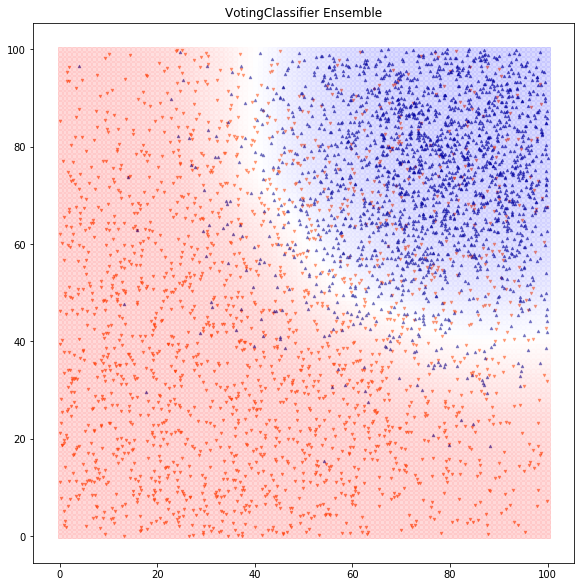

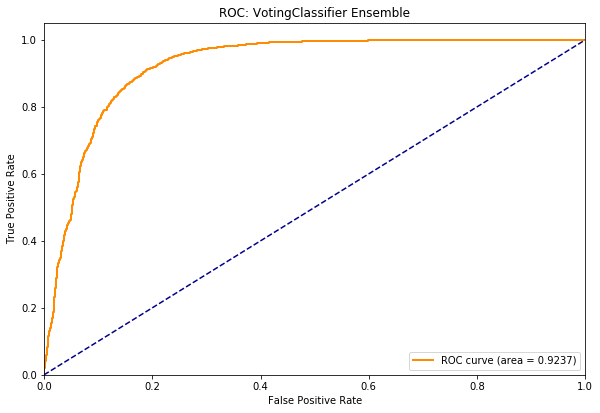

In [35]:
# ensemble of best classifiers
# selected using which metrics? 
# CV accuracy.
# The answer is never a test metric.
# (unless the question is, 'what do you never use to make a decision about your model?')

ensemble_estimators = [
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(),
    #sklearn.neural_network.multilayer_perceptron.MLPClassifier(),
    #sklearn.ensemble.gradient_boosting.GradientBoostingClassifier(),
    #sklearn.ensemble.weight_boosting.AdaBoostClassifier(),
    xgboost.sklearn.XGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001, nthreads=-1),
    #catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent'),    
    sklearn.naive_bayes.GaussianNB(),
    kerasClassifierFactory()(),
]


estimator_names = [
    'QuadraticDiscriminantAnalysis',
    #'MLPClassifier',
    #'GradientBoostingClassifier',
    #'AdaBoostClassifier',
    'XGBoost Classifier',
    #'CatBoost Classifier',
    'GaussianNB',
    'KerasNN',
]

vc = VotingClassifier(estimators=list(zip(estimator_names, ensemble_estimators)), voting='soft')
vc.fit(X, y)
y_pred = vc.predict(X)
print("In-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y, y_pred))

# select threshold using CV data to maximize accuracy
#y_cv_pred_prob = vc.predict_proba(X_cv)[:,1]
#thresh = select_threshold(y_cv, y_cv_pred_prob, sklearn.metrics.accuracy_score)
#y_cv_pred = y_cv_pred_prob > thresh
#y_cv_pred = vc.predict(X_cv)
#acc = sklearn.metrics.accuracy_score(y_cv, y_cv_pred)
#f1_score = sklearn.metrics.f1_score(y_cv, y_cv_pred)
#print("CV Threshold %.4f Accuracy %.4f F1 %.4f" % (thresh, acc, f1_score))

# evaluate estimator using test data
#y_test_pred_proba = vc.predict_proba(X_test)
#y_test_pred = y_test_pred_prob > thresh
y_test_pred = vc.predict(X_test)
print("Out-Of-Sample Accuracy: %.4f" % sklearn.metrics.accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
print (conf_mat)
print("(True negative %d True positive %d False positive %d False negative %d)" % (conf_mat[0][0], conf_mat[1][1], conf_mat[1][0], conf_mat[0][1], ))

z = vc.predict_proba(X_pred)
if len(z.shape) == 1:
    z = z.reshape(z.shape[0], 1)

Z = np.hstack([X_pred, z])
class_chart_matplotlib(class1_test, class2_test, Z, "VotingClassifier Ensemble", bgsize=15)    
try:
    roc_chart(vc, X_test, y_test, "ROC: VotingClassifier Ensemble")
except:
    pass